In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

In [2]:
dataset = pd.read_csv("creditcard.csv")

In [3]:
print("Any nulls in the dataset ", dataset.isnull().values.any())
print('---')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values", dataset.Class.unique())
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts (dataset ['Class'], sort = True))

Any nulls in the dataset  True
---
No. of unique labels  3
Label values [ 0.  1. nan]
-------
Break down of the Normal and Fraud Transactions
0.0    9926
1.0      38
Name: Class, dtype: int64


Text(0, 0.5, 'Number of Observations')

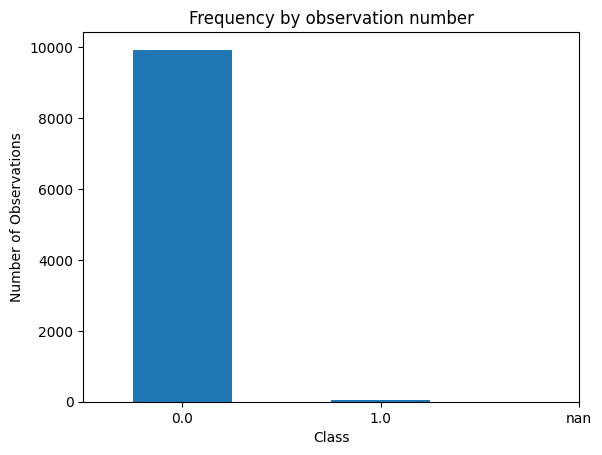

In [4]:
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset['Class'].unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

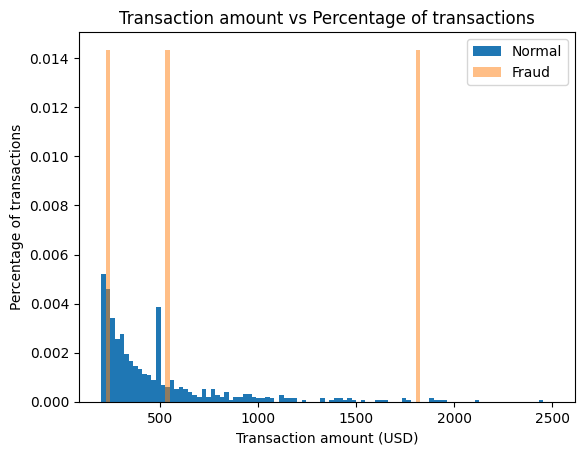

In [5]:
import matplotlib.pyplot as plt
import numpy as np

normal_dataset = dataset[dataset['Class'] == 0]
fraud_dataset = dataset[dataset['Class'] == 1]

# Specify bin edges using np.linspace
bins = np.linspace(200, 2500, 100)

with np.errstate(divide='ignore', invalid='ignore'):
    plt.hist(normal_dataset['Amount'], bins, alpha=1, density=True, label='Normal')
    plt.hist(fraud_dataset['Amount'], bins, alpha=0.5, density=True, label='Fraud')

plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions")

plt.show()

In [6]:
sc = StandardScaler()
dataset ['Time'] = sc.fit_transform(dataset [ 'Time'].values.reshape(-1, 1))
dataset ['Amount'] = sc.fit_transform(dataset ['Amount'].values .reshape(-1, 1))

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
raw_data = dataset.values
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=2021)


In [8]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data- min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [9]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print(" No. of records in Fraud Train Data=", len(fraud_train_data))
print(" No. of records in Normal Train data=",len (normal_train_data))
print(" No. of records in Fraud Test Data=", len(fraud_test_data))
print(" No. of records in Normal Test data=",len (normal_test_data))

 No. of records in Fraud Train Data= 30
 No. of records in Normal Train data= 7942
 No. of records in Fraud Test Data= 9
 No. of records in Normal Test data= 1984


In [10]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2)
hidden_dim_2=4
learning_rate = 1e-7

In [11]:
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
autoencoder = tf.keras.Model(inputs=input_layer ,outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [12]:
cp =tf.keras.callbacks. ModelCheckpoint(filepath="autoencoder_fraud.h5", mode='min', monitor = 'val_loss', verbose=2, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1,mode='min', restore_best_weights=True)

In [13]:
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

In [14]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5", mode= 'min', monitor="val_loss",  verbose = 2, save_best_only = 'True')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', restore_best_weights='True')


In [15]:
history = autoencoder.fit(
    normal_train_data,
    normal_train_data,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(test_data, test_data),
    verbose=1,
    callbacks=[cp, early_stop]
).history

Epoch 1/50
113/125 [==========================>...] - ETA: 0s - loss: 0.1085 - accuracy: 0.0064
Epoch 1: val_loss did not improve from inf
125/125 [==============================] - 2s 5ms/step - loss: 0.1006 - accuracy: 0.0071 - val_loss: nan - val_accuracy: 0.0015
Epoch 2/50
115/125 [==========================>...] - ETA: 0s - loss: 0.0083 - accuracy: 0.0383
Epoch 2: val_loss did not improve from inf
125/125 [==============================] - 0s 3ms/step - loss: 0.0079 - accuracy: 0.0400 - val_loss: nan - val_accuracy: 0.0697
Epoch 3/50
110/125 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 0.0869
Epoch 3: val_loss did not improve from inf
125/125 [==============================] - 0s 3ms/step - loss: 0.0014 - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.1199
Epoch 4/50
110/125 [=========================>....] - ETA: 0s - loss: 3.5809e-04 - accuracy: 0.1263
Epoch 4: val_loss did not improve from inf
125/125 [==============================] - 0s 3ms/step -

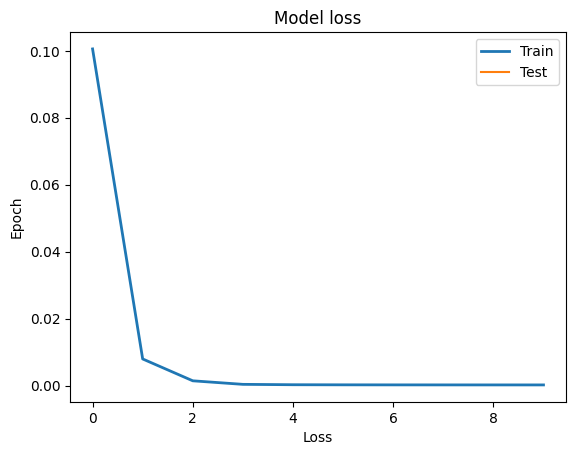

In [16]:
plt.plot(history['loss'], linewidth=2, label = 'Train')
plt.plot(history['val_loss'], label = 'Test')
plt.legend(loc = 'upper right')
plt.title('Model loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.show()

In [17]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class' : test_labels})

63/63 [==============================] - 0s 1ms/step


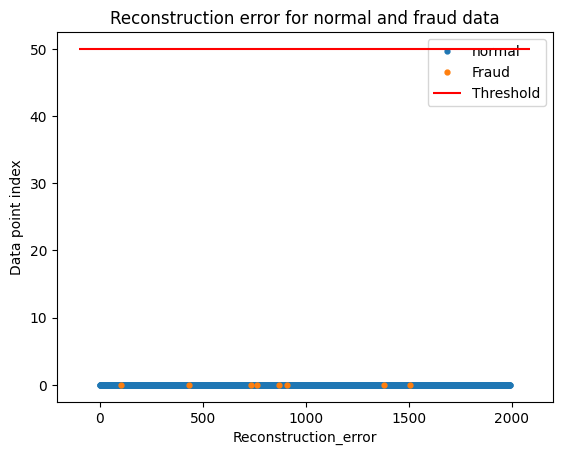

In [18]:
threshold_fixed = 50
groups = error_df.groupby('True_class')

# Create the plot
fix, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index,
            group.Reconstruction_error,
            marker='o',
            ms=3.5,
            linestyle='',
            label="Fraud"
            if name == 1
            else "normal")

# Plot the threshold line outside the loop
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Add legend and labels
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.xlabel("Reconstruction_error")
plt.ylabel("Data point index")

# Show the plot
plt.show()
